In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib 
from matplotlib.ticker import FuncFormatter
from scipy import stats

In [2]:
ALL = pd.read_csv("../Mante/ALL_6.20.25_newTask.csv").iloc[:,1:]
ALL = ALL.dropna()
subject_IDs = np.sort(ALL.subjects.unique())
test_tag = 900263000259957
subject_IDs  = subject_IDs[subject_IDs != test_tag]
# find the two tasks
DURATION = ALL[ALL.task == 24].reset_index(drop=True)
SWEEPDIR = ALL[ALL.task == 29].reset_index(drop=True)

# special processing for SD_left bc data corruption
SWEEPDIR.drop(SWEEPDIR[SWEEPDIR["specific_stims"] == "clicks_32hz_1s_60db.wav"].index, inplace=True) 
ALL = pd.concat([DURATION, SWEEPDIR]).reset_index(drop=True)

In [3]:
# sanity check if the two rules are correct in the filtered data
# should have only two unique stimuli for each actioni in each rule
D_right = DURATION.loc[
    DURATION['trial_types'] == 1, 
    'specific_stims'
].unique()
D_left = DURATION.loc[
    DURATION['trial_types'] == 0, 
    'specific_stims'
].unique()
print(D_right)
print(D_left)

SD_right = SWEEPDIR.loc[
    SWEEPDIR['trial_types'] == 1, 
    'specific_stims'
].unique()
SD_left = SWEEPDIR.loc[
    SWEEPDIR['trial_types'] == 0, 
    'specific_stims'
].unique()
print(SD_right)
print(SD_left)

['fm_50ms_-40octs.wav' 'fm_50ms_+40octs.wav']
['fm_100ms_+40octs.wav' 'fm_100ms_-40octs.wav']
['fm_100ms_-40octs.wav' 'fm_50ms_-40octs.wav']
['fm_50ms_+40octs.wav' 'fm_100ms_+40octs.wav']


In [4]:
#                      Duration short 50ms (RIGHT)    Duration long 100ms (LEFT)        
# SD neg -40 (RIGHT)     (context-invariant)            (context-dependent)
# SR pos +40 (LEFT)     (context-dependent)             (context-invariant)  

# the invariant stimuli are: 'fm_50ms_-40octs.wav', 'fm_100ms_+40octs.wav'
# the context-dependent stimuli are: 'fm_50ms_+40octs.wav', 'fm_100ms_-40octs.wav' 

In [5]:
# load context-dependent and invariant trials for each task
INVARIANT_DURATION = DURATION[
    (DURATION['specific_stims'] == 'fm_50ms_-40octs.wav')
    | 
    (DURATION['specific_stims'] == 'fm_100ms_+40octs.wav')
]
DEPENDENT_DURATION = DURATION[
    (DURATION['specific_stims'] == 'fm_50ms_+40octs.wav')
    | 
    (DURATION['specific_stims'] == 'fm_100ms_-40octs.wav')
]

INVARIANT_SWEEPDIR = SWEEPDIR[
    (SWEEPDIR['specific_stims'] == 'fm_50ms_-40octs.wav')
    | 
    (SWEEPDIR['specific_stims'] == 'fm_100ms_+40octs.wav')
]
DEPENDENT_SWEEPDIR = SWEEPDIR[
    (SWEEPDIR['specific_stims'] == 'fm_50ms_+40octs.wav')
    | 
    (SWEEPDIR['specific_stims'] == 'fm_100ms_-40octs.wav')
]

In [6]:
colors = ['#FFC07F', # Arena A -> duration
          '#94c47d', #  Arena B -> sweep rate
          '#4AA9FC', # context-dep
          "#A1A7B0"] # context-inv

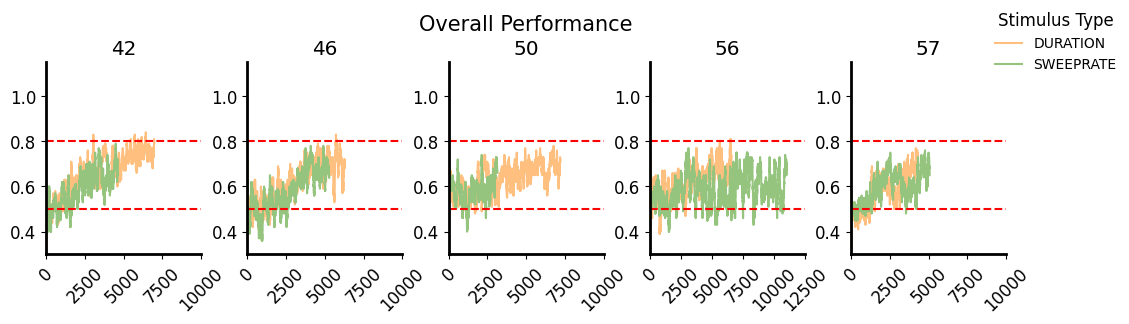

In [7]:
# plot the overall performance in both tasks
fig = plt.figure(figsize=(12, 6))
roll_size = 100
import matplotlib 
import math
matplotlib.rcParams['font.size'] = 12
idx = 1
for subject in subject_IDs:
    ax = plt.subplot(2,5, idx)
    
    if subject == 900263000259957:
        sub_sweepdir = SWEEPDIR.loc[SWEEPDIR.subjects == subject].reset_index(drop=True)
        sub_duration = DURATION.loc[DURATION.subjects == subject].reset_index(drop=True)
        sub_duration.outcomes.rolling(5, min_periods=1).mean().plot(ax=ax,label="DURATION", color=colors[0])
        sub_sweepdir.outcomes.rolling(5, min_periods=1).mean().plot(ax=ax,label="SWEEPRATE", color=colors[1])
        plt.title(f'{str(subject)[-3:]}')
        idx += 1
        ax.axhline(0.8, color='red', ls='--')
        ax.axhline(0.5, color='red', ls='--')
        x_max = max(len(sub_duration), len(sub_sweepdir))
        lim_x = 100
        ax.set_xlim(0, lim_x) 
        ax.set_xticks(np.arange(0, lim_x+1, 10))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.set_ylim(0.3, 1.15)  
        ax.set_yticks(np.arange(0.4, 1.1, 0.2))

        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        sub_sweepdir = SWEEPDIR.loc[SWEEPDIR.subjects == subject].reset_index(drop=True)
        sub_duration = DURATION.loc[DURATION.subjects == subject].reset_index(drop=True)
        sub_duration.outcomes.rolling(roll_size, min_periods=1).mean().plot(ax=ax,label="DURATION", color=colors[0])
        sub_sweepdir.outcomes.rolling(roll_size, min_periods=1).mean().plot(ax=ax,label="SWEEPRATE", color=colors[1])
        plt.title(f'{str(subject)[-2:]}')
        idx += 1
        ax.axhline(0.8, color='red', ls='--')
        ax.axhline(0.5, color='red', ls='--')
        x_max = max(len(sub_duration), len(sub_sweepdir))
        if x_max < 10000:
            lim_x = 10000
        else:
            lim_x = math.ceil(x_max / 2500) * 2500
        ax.set_xlim(0, lim_x) 
        ax.set_xticks(np.arange(0, lim_x+1, 2500))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.set_ylim(0.3, 1.15)  
        ax.set_yticks(np.arange(0.4, 1.1, 0.2))

        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_linewidth(2)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.subplots_adjust(
    hspace=0.5,    # increase vertical padding between rows
    wspace=0.3,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)
plt.suptitle('Overall Performance', fontsize=15)
handles, labels = ax.get_legend_handles_labels()

# add a single legend for the whole figure
fig.legend(
    handles,
    labels,
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    title='Stimulus Type',
    fontsize = 10,
    frameon = False
)
plt.show()

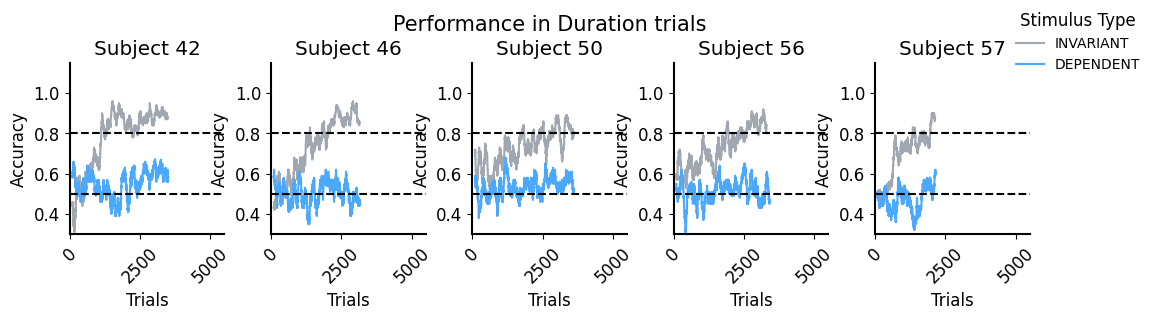

In [8]:
# plot separately for context-dependent and -invariant stimuli in duration trials
fig = plt.figure(figsize=(12, 6))
matplotlib.rcParams['font.size'] = 12
idx = 1
for subject in subject_IDs:
    ax = plt.subplot(2, 5, idx)
    if subject == 900263000259957:
        sub_inv_duration = INVARIANT_DURATION.loc[INVARIANT_DURATION.subjects == subject].reset_index(drop=True)
        sub_inv_duration.outcomes.rolling(5, min_periods=1).mean().plot(ax=ax,label="INVARIANT", color=colors[3])
        sub_dep_duration = DEPENDENT_DURATION.loc[DEPENDENT_DURATION.subjects == subject].reset_index(drop=True)
        sub_dep_duration.outcomes.rolling(5, min_periods=1).mean().plot(ax=ax,label="DEPENDENT", color=colors[2])
        plt.title(f'Subject {str(subject)[-3:]}')
        idx += 1
        ax.axhline(0.8, color='black', ls='--')
        ax.axhline(0.5, color='black', ls='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        x_max = max(len(sub_inv_duration), len(sub_dep_duration))
        lim_x = 50
        ax.set_xlim(0, lim_x) 
        ax.set_xticks(np.arange(0, lim_x+1, 10))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.set_ylim(0.3, 1.15)  
        ax.set_yticks(np.arange(0.4, 1.1, 0.2))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Trials')
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        sub_inv_duration = INVARIANT_DURATION.loc[INVARIANT_DURATION.subjects == subject].reset_index(drop=True)
        sub_inv_duration.outcomes.rolling(100).mean().plot(ax=ax,label="INVARIANT", color=colors[3])
        sub_dep_duration = DEPENDENT_DURATION.loc[DEPENDENT_DURATION.subjects == subject].reset_index(drop=True)
        sub_dep_duration.outcomes.rolling(100).mean().plot(ax=ax,label="DEPENDENT", color=colors[2])
        plt.title(f'Subject {str(subject)[-2:]}')
        idx += 1
        ax.axhline(0.8, color='black', ls='--')
        ax.axhline(0.5, color='black', ls='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        x_max = max(len(sub_inv_duration), len(sub_dep_duration))
        if x_max < 5500:
            lim_x = 5500
        else:
            lim_x = math.ceil(x_max / 2500) * 2500
        ax.set_xlim(0, lim_x) 
        ax.set_xticks(np.arange(0, lim_x+1, 2500))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.set_ylim(0.3, 1.15)  
        ax.set_yticks(np.arange(0.4, 1.1, 0.2))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Trials')
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)


plt.subplots_adjust(
    hspace=0.8,    # increase vertical padding between rows
    wspace=0.3,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)
plt.suptitle('Performance in Duration trials', fontsize=15)
# collect handles + labels from the last axes (or any one axes—it’s the same labels)
handles, labels = ax.get_legend_handles_labels()

# add a single legend for the whole figure
fig.legend(
    handles,
    labels,
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    title='Stimulus Type',
    fontsize = 10,
    frameon = False
)
plt.show()

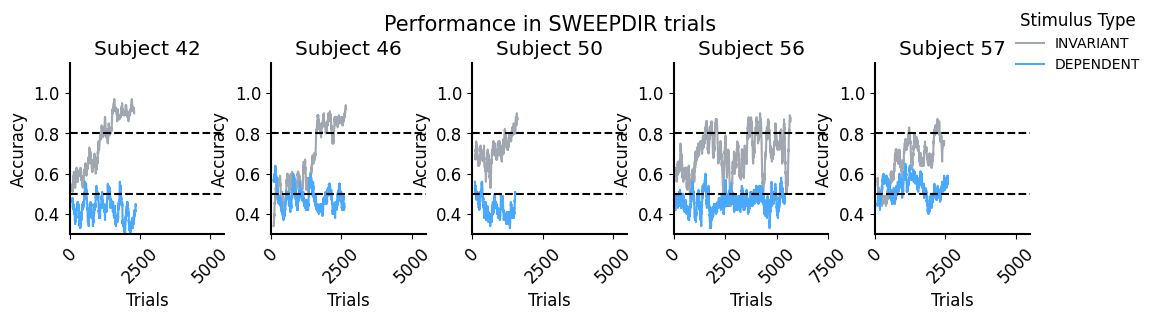

In [9]:
# # plot separately for context-dependent and -invariant stimuli in SWEEPDIR trials
fig = plt.figure(figsize=(12, 6))
matplotlib.rcParams['font.size'] = 12
idx = 1
for subject in subject_IDs:
    ax = plt.subplot(2, 5, idx)
    if subject == 900263000259957:
        sub_inv_sweepdir = INVARIANT_SWEEPDIR.loc[INVARIANT_SWEEPDIR.subjects == subject].reset_index(drop=True)
        sub_inv_sweepdir.outcomes.rolling(5, min_periods=1).mean().plot(ax=ax,label="INVARIANT", color=colors[3])
        sub_dep_sweepdir = DEPENDENT_SWEEPDIR.loc[DEPENDENT_SWEEPDIR.subjects == subject].reset_index(drop=True)
        sub_dep_sweepdir.outcomes.rolling(5, min_periods=1).mean().plot(ax=ax,label="DEPENDENT", color=colors[2])
        plt.title(f'Subject {str(subject)[-3:]}')
        idx += 1
        ax.axhline(0.8, color='black', ls='--')
        ax.axhline(0.5, color='black', ls='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        x_max = max(len(sub_inv_sweepdir), len(sub_dep_sweepdir))
        lim_x = 50
        ax.set_xlim(0, lim_x) 
        ax.set_xticks(np.arange(0, lim_x+1, 10))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.set_ylim(0.3, 1.15)  
        ax.set_yticks(np.arange(0.4, 1.1, 0.2))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Trials')
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    else:
        sub_inv_sweepdir = INVARIANT_SWEEPDIR.loc[INVARIANT_SWEEPDIR.subjects == subject].reset_index(drop=True)
        sub_inv_sweepdir.outcomes.rolling(100).mean().plot(ax=ax,label="INVARIANT", color=colors[3])
        sub_dep_sweepdir = DEPENDENT_SWEEPDIR.loc[DEPENDENT_SWEEPDIR.subjects == subject].reset_index(drop=True)
        sub_dep_sweepdir.outcomes.rolling(100).mean().plot(ax=ax,label="DEPENDENT", color=colors[2])
        plt.title(f'Subject {str(subject)[-2:]}')
        idx += 1
        ax.axhline(0.8, color='black', ls='--')
        ax.axhline(0.5, color='black', ls='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        x_max = max(len(sub_inv_sweepdir), len(sub_dep_sweepdir))
        if x_max < 5500:
            lim_x = 5500
        else:
            lim_x = math.ceil(x_max / 2500) * 2500
        ax.set_xlim(0, lim_x) 
        ax.set_xticks(np.arange(0, lim_x+1, 2500))
        ax.set_xticklabels(ax.get_xticks(), rotation=45)
        ax.set_ylim(0.3, 1.15)  
        ax.set_yticks(np.arange(0.4, 1.1, 0.2))
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Trials')
        ax.spines['bottom'].set_linewidth(1.5)
        ax.spines['left'].set_linewidth(1.5)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
plt.subplots_adjust(
    hspace=0.8,    # increase vertical padding between rows
    wspace=0.3,    # horizontal padding (if multiple columns)
    top=0.9,       # leave 10% space at top
    bottom=0.1,    # leave 10% space at bottom
    left=0.1,      # 10% margin on left
    right=0.9      # 10% margin on right
)
plt.suptitle('Performance in SWEEPDIR trials', fontsize=15)
# collect handles + labels from the last axes (or any one axes—it’s the same labels)
handles, labels = ax.get_legend_handles_labels()

# add a single legend for the whole figure
fig.legend(
    handles,
    labels,
    loc='upper right',    # position above all subplots
    ncol=1,                # number of columns in the legend
    title='Stimulus Type',
    fontsize=10,
    frameon = False
)
plt.show()

# Plot the swith frequency and initial performance

In [10]:
'''Helper functions'''
def process_block_data(subject_data):
    subject_data = subject_data.sort_values("times").reset_index(drop=True)
    subject_data["trial_idx"] = subject_data.index

    # (a) contiguous-block labels
    subject_data['block_id'] = subject_data['task'].ne(
        subject_data['task'].shift()
    ).cumsum()

    # (b) trial index *within* each block
    subject_data['within_block_idx'] = (
        subject_data
        .groupby('block_id')
        .cumcount()
    )

    # (c) block length for every trial 
    block_len = (
        subject_data.groupby('block_id')
        .size()
        .rename('block_len')
    )
    subject_data_processed = subject_data.join(block_len, on='block_id')
    return subject_data_processed

def boxplot_trialnum(subject_data_processed, subject, ax):
    block_len_df = (
        subject_data_processed[['task', 'block_id', 'block_len']]
        .drop_duplicates()
        .reset_index(drop=True)
    )

    Duration_len = block_len_df.loc[block_len_df['task'] == 24, 'block_len']
    SweepRate_len = block_len_df.loc[block_len_df['task'] == 29, 'block_len']
    data = [Duration_len, SweepRate_len]

    palette = {24: colors[0], 29: colors[1]} 

    bp = ax.boxplot(
        data,
        patch_artist=True,
        widths=0.6,
        positions=[1.0, 1.75],
        boxprops    = dict(edgecolor='black',linewidth = 1.5),
        medianprops = dict(color='black', linewidth=1.5),
        whiskerprops= dict(color='black'),
        capprops    = dict(color='black')
    )

    box_colors = [palette[24], palette[29]]
    for box, col in zip(bp['boxes'], box_colors):
        box.set_facecolor(col)
        box.set_alpha(0.8) 

    rng      = np.random.default_rng(1)
    jitter   = 0
    dot_area = 55

    # Duration dots (blue)
    x24 = 1 + rng.uniform(-jitter, jitter, len(Duration_len))
    ax.scatter(
        x24, Duration_len,
        marker='o',
        s=dot_area,
        facecolors=palette[24],   # your blue
        edgecolors='black',
        linewidths=0.8,
        zorder=2
    )

    # SweepRate dots (orange)
    x29 = 1.75 + rng.uniform(-jitter, jitter, len(SweepRate_len))
    ax.scatter(
        x29, SweepRate_len,
        marker='o',
        s=dot_area,
        facecolors=palette[29],   # your orange
        edgecolors='black',
        linewidths=0.8,
        zorder=2
    )
    ax.set_title(f'Subject {str(subject)[-2:]}')
    # ax.set_ylim([-100,750])
    ax.set_xlim([0.5, 2.1])
    ax.set_xticklabels(['Arena A', 'Arena B'], fontsize = 8)
    ax.set_ylabel('# trials before switch')
    ax.grid(axis='y', linestyle='--', alpha=0.35)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.tight_layout()
    # plt.savefig('switch_frequency.pdf',bbox_inches='tight')
    # plt.show()
    return Duration_len, SweepRate_len
    
def trial_length_average_and_ttest(Duration_len, SweepRate_len):
    t_stat, p_val = stats.ttest_ind(Duration_len, SweepRate_len, equal_var=False)  # Welch’s t-test
    if p_val > 0.05:
        print(f'Subject stays in either arena does NOT significantly differ: t = {t_stat:.3f},  p = {p_val:.4f}')
    else:
        print(f'Subject stays in either arena DOES significantly differ: t = {t_stat:.3f},  p = {p_val:.4f}')
    Duration_len_mean = np.mean(Duration_len)
    Duration_len_se = Duration_len.std(ddof=1) / np.sqrt(len(Duration_len))
    SweepRate_len_mean = np.mean(SweepRate_len)
    SweepRate_len_se = SweepRate_len.std(ddof=1) / np.sqrt(len(SweepRate_len))
    print(f'Duration task on average runs for {Duration_len_mean} trials +- {Duration_len_se:.2f}')
    print(f'SweepRate task on average runs for {SweepRate_len_mean} trials +- {SweepRate_len_se:.2f}')

def plot_afterswitch_performance(subject_data, subject, ax, max_k = 20):
    palette = {24: colors[0], 29: colors[1]} 
    trimmed = subject_data[subject_data['within_block_idx'] < max_k].copy()

    summ = (
        trimmed
        .groupby(['task', 'within_block_idx'])['outcomes']
        .agg(mean='mean', count='count', std='std')
        .reset_index()
    )
    summ['sem'] = summ['std'] / np.sqrt(summ['count'])

    #smoothing
    for col in ['mean', 'sem']:
        summ[f'smooth_{col}'] = (
            summ
            .groupby('task')[col]
            .transform(lambda s: s.rolling(3,
                                            center=True,
                                            min_periods=1).mean())
        )

    for task_val in (24, 29):
        g  = summ[summ['task'] == task_val]
        x  = g['within_block_idx']
        m  = g['smooth_mean']
        se = g['smooth_sem']
        cur_label = 'Arena A' if task_val == 24 else 'Arena B'
        ax.plot(x, m, color=palette[task_val], label=cur_label)
        ax.fill_between(x, m - se, m + se,
                        color=palette[task_val], alpha=0.25)
    ax.set_title(f'Subject {str(subject)[-2:]}')
    ax.axhline(0.8, color='red', ls='--')
    ax.axhline(0.5, color='black', ls='--')
    ax.set_xlim(-0.5, max_k - 0.5)
    ax.set_xlabel('Trials', fontsize = 9)
    ax.set_ylabel('Accuracy',fontsize = 9)
    ax.set_ylim(0.3, 1.15)  
    ax.set_yticks(np.arange(0.4, 1.1, 0.2))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # plt.tight_layout()
    # plt.savefig('after_switch_accuray.pdf',bbox_inches='tight')
    # plt.show()


Subject stays in either arena does NOT significantly differ: t = 1.156,  p = 0.2536
Duration task on average runs for 199.57142857142858 trials +- 49.57
SweepRate task on average runs for 136.5 trials +- 22.83
Subject stays in either arena does NOT significantly differ: t = 0.477,  p = 0.6358
Duration task on average runs for 161.43589743589743 trials +- 51.05
SweepRate task on average runs for 135.4102564102564 trials +- 19.38
Subject stays in either arena DOES significantly differ: t = 2.029,  p = 0.0491
Duration task on average runs for 200.05555555555554 trials +- 54.96
SweepRate task on average runs for 84.75675675675676 trials +- 14.39
Subject stays in either arena does NOT significantly differ: t = -1.171,  p = 0.2425
Duration task on average runs for 39.55882352941177 trials +- 12.94
SweepRate task on average runs for 65.02352941176471 trials +- 17.47
Subject stays in either arena does NOT significantly differ: t = -0.357,  p = 0.7222
Duration task on average runs for 110.20512

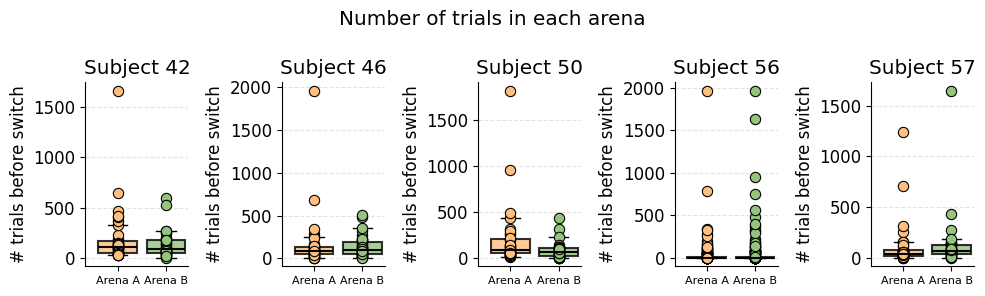

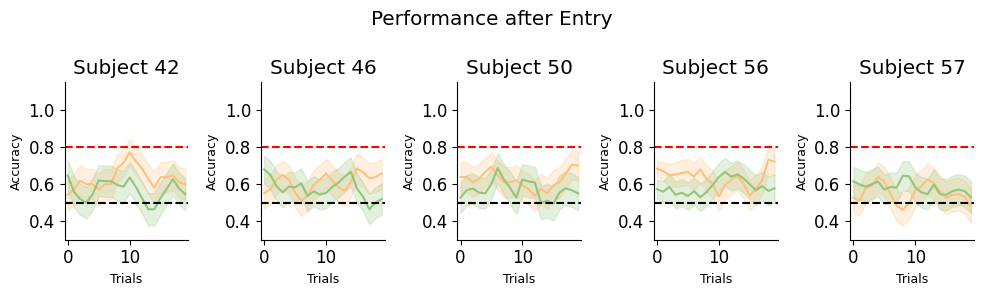

In [11]:
fig1, axgrid1 = plt.subplots(1, 5, figsize=(10, 3))   # box-plots
fig2, axgrid2 = plt.subplots(1, 5, figsize=(10, 3))   # after-switch curves

matplotlib.rcParams['font.size'] = 12
for idx, subject in enumerate(subject_IDs):
    # row, col = divmod(idx, 5)
    
    ax1   = axgrid1[idx]      
    ax2 = axgrid2[idx] 

    subject_data = ALL.loc[ALL.subjects == subject].reset_index(drop=True)
    subject_data_processed = process_block_data(subject_data)
    Duration_len, SweepRate_len = boxplot_trialnum(subject_data_processed, subject, ax1)
    trial_length_average_and_ttest(Duration_len, SweepRate_len)
    plot_afterswitch_performance(subject_data_processed, subject, ax2)

fig1.suptitle('Number of trials in each arena')
fig1.tight_layout()
fig2.suptitle('Performance after Entry')
fig2.tight_layout()

plt.show()